# Solving the stochastic/rough Poisson equation

We aim to solve the Poisson equation in 1-D
$$
-\Delta u = f \quad \text{in} \quad(0, L) \\
u(x) = 0 \quad \text{for} \quad x = 0, L
$$

We will choose $u$ of the form:
$$
u = \sum_{n=1}^\infty a_n \sqrt{\frac{2}{L}}\sin\Big(\frac{n\pi x}{L}\Big)
$$

The functions 
$$
 \sqrt{\frac{2}{L}}\sin\Big(\frac{n\pi x}{L}\Big)
$$
form an orthonrmal basis of $L^2(0, L)$. Moreover 
$$
-\Delta  \sqrt{\frac{2}{L}}\sin\Big(\frac{n\pi x}{L}\Big) =  \frac{n^2\pi^2}{L^2}\sqrt{\frac{2}{L}}\sin\Big(\frac{n\pi x}{L}\Big) = \lambda_n \sqrt{\frac{2}{L}}\sin\Big(\frac{n\pi x}{L}\Big)
$$

In this way we have that 
$$
-\Delta u =  \sum_{n=1}^\infty a_n \frac{n^2\pi^2}{L^2}\sqrt{\frac{2}{L}}\sin\Big(\frac{n\pi x}{L}\Big) = f
$$
We will select the coefficients 
$$
a_n = \frac{\xi_n}{n^{\frac{2+ \frac{1}{2}}{2}}}  \quad \xi_n \sim \mathcal{N}(0,1) \; \text{i.i.d.}
$$
so that 
$$
||u||^2_{H^1} = \sum_{n=1}\frac{\xi^2_n}{n^{2 + \frac{1}{2}}}\lambda_n \propto \sum_{n=1}\frac{\xi^2_n}{n^{2 + \frac{1}{2}}}n^2 = \sum_{n=1}\frac{\xi^2_n}{n^\frac{1}{2}} < \infty \quad \text{a.s.}
$$
Therefore $f \in H^{-1}$ a.s.. In fact $u \in H^{1 + \frac{1}{4} -\delta}$ for any $\delta >0$ and so $f \in H^{-1 + \frac{1}{4} - \delta}$ for any $\delta >0$. 

In [7]:
import jax.numpy as jnp
from jax import random
from jax import scipy 

import matplotlib.pyplot as plt

In [8]:
import utils_rough_pde
from utils_rough_pde import *

In [64]:
# draw random values for the coefficients
key = random.PRNGKey(1)

n_coef = 1000
decay_u = 2.5# 1.25 # Regularity of u
L = 1 # Lenght of the domain
coef_u = random.normal(key, shape=(n_coef,))/(jnp.arange(1, n_coef+1)**(decay_u))

coef_f = coef_u*jnp.arange(1, n_coef+1)**(2)*jnp.pi**2*L**2

x = jnp.linspace(0, L, 1200)
u_values = evaluate_function(x, coef_u, L=L)
f_values = evaluate_function(x, coef_f, L=L)

Text(0.5, 1.0, 'Function f')

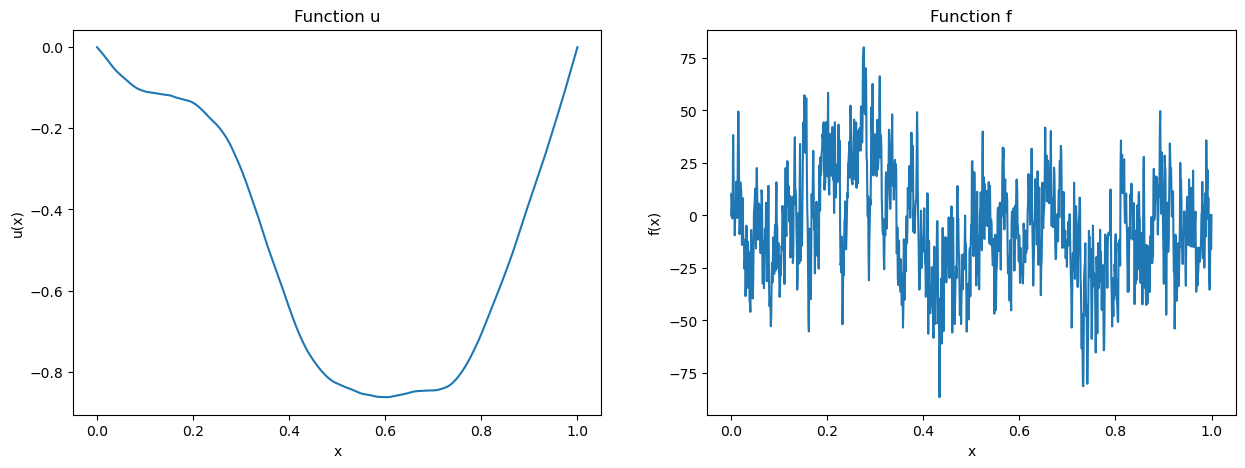

In [65]:
# Create 2 plots for the  function u and f
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x, u_values)
ax[0].set_xlabel("x")
ax[0].set_ylabel("u(x)")
ax[0].set_title("Function u")

ax[1].plot(x, f_values)
ax[1].set_xlabel("x")
ax[1].set_ylabel("f(x)")
ax[1].set_title("Function f")


# Defining our weak measurements

In [11]:
epsilon_values =  jnp.array([0.01])

# Boundary of the domain
lower, upper = 0.0, 1.0

loc_values = jnp.linspace(lower + epsilon_values[0], upper - epsilon_values[0],  int(L/(2*epsilon_values[0])))
support = jnp.array([loc_values - epsilon_values[0], loc_values + epsilon_values[0]]).T
vol = support[:,1] - support[:,0]
N_test_functions = loc_values.shape[0]

print("Number of test functions: ", N_test_functions)

Number of test functions:  50


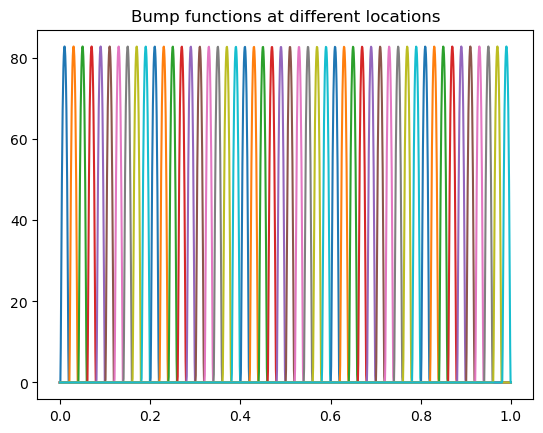

In [12]:
bump_values = vmap_bump(x, epsilon_values, loc_values)

for i, loc in enumerate(loc_values):
    plt.plot(x, bump_values[:, 0, i])
plt.title("Bump functions at different locations")
plt.show()

In [13]:
from scipy.special import roots_legendre
n_order = 999
x_q, w_q = roots_legendre(n_order)
root_psi, w_psi = vmap_root_interval(x_q, w_q, support)

# Construct the mmatrix of weighted bump functions 
psi_matrix = bump_vector(root_psi, epsilon_values, loc_values)
psi_matrix = psi_matrix * w_psi

# Solving the Poisson equation

To solve the Poisson equation, we solve the following linear system
$$
\Theta \bold{c} = Y
$$
where 
$$
Y = \begin{bmatrix}
\bold{0} \\
[f, \psi]
\end{bmatrix}
$$
and
$$
\Theta = \begin{bmatrix}
K(X_{\partial\Omega},X_{\partial\Omega}) &  -\Delta_y K(X_{\partial\Omega}, \boldsymbol{\psi}) \\
-\Delta_y K( X_{\partial\Omega}, \boldsymbol{\psi})^\intercal & \Delta_x\Delta_y K( \boldsymbol{\psi}, \boldsymbol{\psi})
\end{bmatrix}
$$

The resulting function is given by 
$$
\begin{pmatrix}
K(\cdot \;,  X_{\partial\Omega}),  -\Delta_y K(\cdot \;, \boldsymbol{\psi})
\end{pmatrix}\bold{c}
$$

# Observing the convergence rates

In [14]:
n_meas_list = jnp.arange(10, 70, 10, dtype=int)
# Boundary of the domain
lower, upper = 0.0, 1.0
length_scale = 0.1
boundary = jnp.array([[lower, upper]]).T

nugget_interior = 1e-6
nugget_boundary = 1e-10

In [18]:
error_list = []
relative_error_list = []

pred_list = []
for n_meas in n_meas_list:

    # Construct the measurements
    epsilon_values =  jnp.array([1/(n_meas*2)])
    loc_values = jnp.linspace(lower + epsilon_values[0], upper - epsilon_values[0],  int(L/(2*epsilon_values[0])))
    support = jnp.array([loc_values - epsilon_values[0], loc_values + epsilon_values[0]]).T
    vol = support[:,1] - support[:,0]
    N_test_functions = loc_values.shape[0]

    print("Number of test functions: ", N_test_functions)

    # Construct the mmatrix of weighted bump functions 
    root_psi, w_psi = vmap_root_interval(x_q, w_q, support)
    psi_matrix = bump_vector(root_psi, epsilon_values, loc_values)
    psi_matrix = psi_matrix * w_psi

    # Compute the RHS of the linear system
    f_quad = evaluate_function(root_psi, coef_f, L)
    f_meas = vmap_integrate_f_test_functions(f_quad, psi_matrix)

    # Construct the RHS of the linear system
    Y = jnp.block([jnp.zeros(shape = 2), f_meas])

    # Compute the kernel matrix
    print("Constructing the kernel matrix")
    theta = construct_theta(boundary,psi_matrix, root_psi, length_scale)

    # Construct the nugget
    nugget = jnp.block([nugget_boundary*jnp.ones(shape = 2), nugget_interior*jnp.ones(shape = N_test_functions)])

    # Solve the linear system
    print("Solving the linear system")
    c = scipy.linalg.solve(theta + nugget*jnp.eye(theta.shape[0]), Y, assume_a='pos')

    # Compute the numerical solution
    pred = evaluate_prediction(x, c, length_scale, root_psi, psi_matrix, boundary)
    pred_list.append(pred)

    # Compute the error between the true solution and the numerical solution
    loss, relative_loss = compute_error(pred, u_values)
    error_list.append(loss)
    relative_error_list.append(relative_loss)




error_list = jnp.array(error_list)
relative_error_list = jnp.array(relative_error_list)

pred_list = jnp.array(pred_list)


Number of test functions:  10
Constructing the kernel matrix
Solving the linear system
Number of test functions:  20
Constructing the kernel matrix
Solving the linear system
Number of test functions:  30
Constructing the kernel matrix
Solving the linear system
Number of test functions:  40
Constructing the kernel matrix
Solving the linear system
Number of test functions:  50
Constructing the kernel matrix
Solving the linear system
Number of test functions:  60
Constructing the kernel matrix
Solving the linear system


Text(0.5, 1.0, 'Relative error')

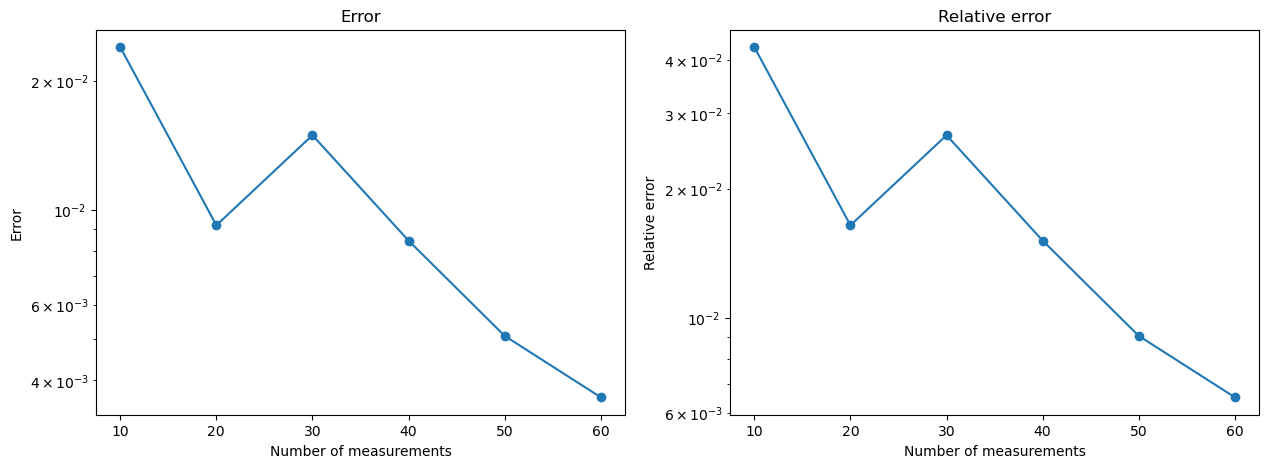

In [25]:
# Plot both the error and the relative error
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(n_meas_list, error_list)
ax[0].scatter(n_meas_list, error_list)
ax[0].set_yscale("log")
ax[0].set_xlabel("Number of measurements")
ax[0].set_ylabel("Error")
ax[0].set_title("Error")

ax[1].plot(n_meas_list, relative_error_list)
ax[1].scatter(n_meas_list, relative_error_list)
ax[1].set_yscale("log")
ax[1].set_xlabel("Number of measurements")
ax[1].set_ylabel("Relative error")
ax[1].set_title("Relative error")


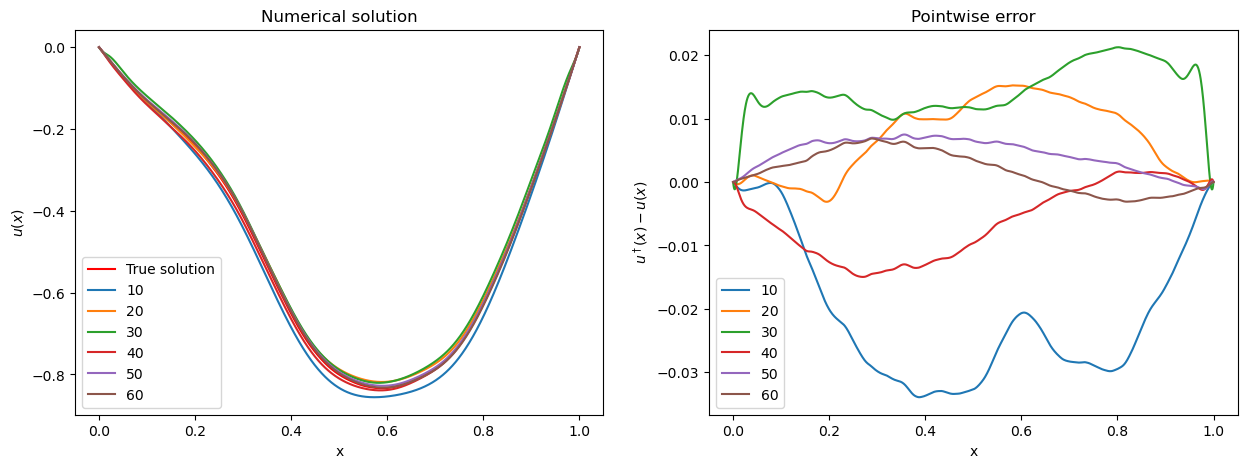

In [61]:
# For each prediction, plot the true solution and the numerical solution and the error
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x, u_values, label = "True solution", color = "Red")
for i, pred in enumerate(pred_list):
    ax[0].plot(x, pred, label = "{}".format(n_meas_list[i]))
    ax[0].set_xlabel("x")
    ax[0].set_ylabel(r"$u(x)$")
    ax[0].set_title("Numerical solution")

    ax[1].plot(x, pred - u_values, label = "{}".format(n_meas_list[i]))
    ax[1].set_xlabel("x")
    ax[1].set_ylabel(r"$u^\dagger(x) - u(x)$")
    ax[1].set_title("Pointwise error")


ax[0].legend()
ax[1].legend()

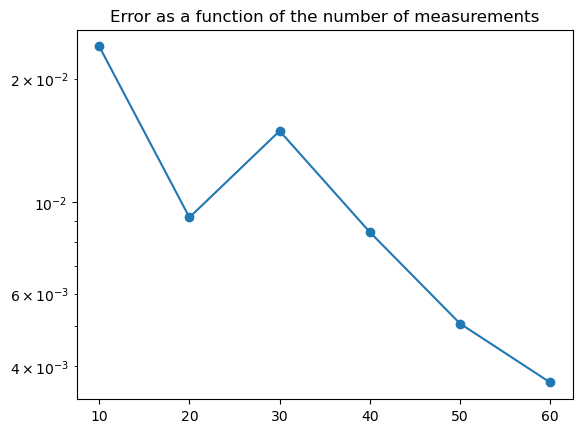

In [20]:
plt.plot(n_meas_list, error_list, label="L^2 error")
plt.scatter(n_meas_list, error_list)
plt.title("Error as a function of the number of measurements")
plt.yscale("log")

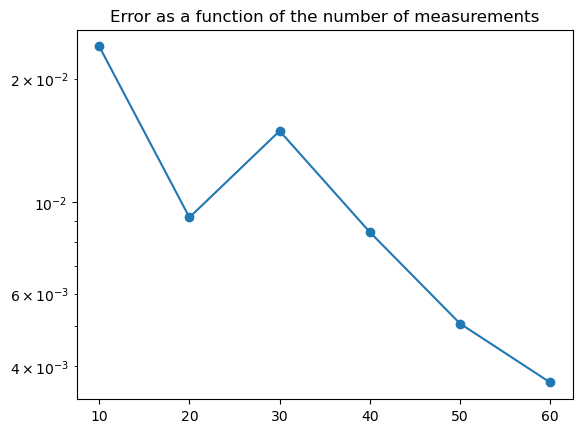

In [21]:
plt.plot(n_meas_list, error_list, label="L^2 error")
plt.scatter(n_meas_list, error_list)
plt.title("Error as a function of the number of measurements")
plt.yscale("log")

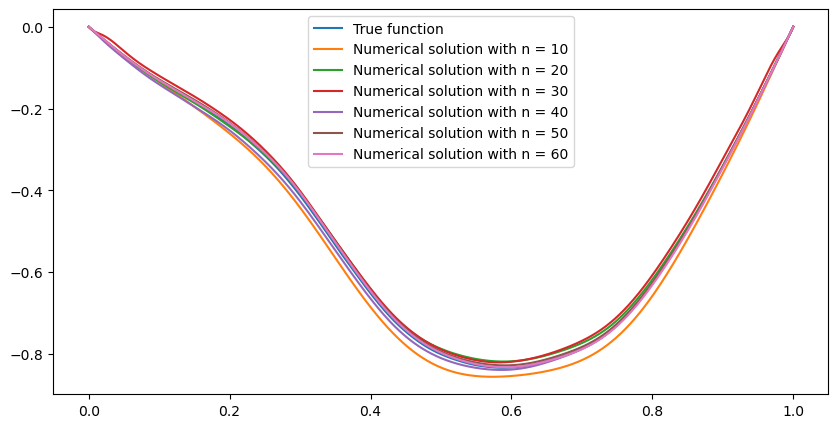

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(x, u_values, label="True function")
for i, pred in enumerate(pred_list):
    plt.plot(x, pred, label="Numerical solution with n = {}".format(n_meas_list[i]))

plt.legend()
plt.show()